<a href="https://colab.research.google.com/github/BuberDev/Artificial-Intelligence-ComputerVision/blob/main/Klasyfikator_binarny_Drone_vs_Passenger_Plane.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Import bibliotek

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil

import plotly.graph_objects as go
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

np.set_printoptions(precision=12, suppress=True, linewidth=120)


## 2. Zaladowanie danych

In [2]:
!wget https://storage.googleapis.com/esmartdata-courses-files/ann-course/flying-vehicles.zip

--2023-07-06 21:32:20--  https://storage.googleapis.com/esmartdata-courses-files/ann-course/flying-vehicles.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.171.128, 142.250.159.128, 142.251.120.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.171.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1540232238 (1.4G) [application/x-zip-compressed]
Saving to: ‘flying-vehicles.zip’

flying-vehicles.zip 100%[===================>]   1.43G  32.8MB/s    in 46s     

2023-07-06 21:33:07 (31.8 MB/s) - ‘flying-vehicles.zip’ saved [1540232238/1540232238]



In [3]:
!unzip -q flying-vehicles.zip

Przygotowanie zbiorow: treningowego, walidacyjnego i testowego

In [4]:
base_dir = './data/planes'
raw_no_of_files = {}
classes = ['drone', 'fighter-jet', 'helicopter', 'missile', 'passenger-plane', 'rocket']

# Ponizszy fragment kodu sprawdzi nam ile mamy zdiec dla poszczegolnych klass (tych wyzej)
for dir in classes:
  raw_no_of_files[dir] = len(os.listdir(os.path.join(base_dir, dir)))

raw_no_of_files.items()

dict_items([('drone', 1332), ('fighter-jet', 1867), ('helicopter', 1387), ('missile', 1334), ('passenger-plane', 1424), ('rocket', 1186)])

In [5]:
from IPython.lib.display import exists
# Torzymy katalog images
data_dir = './images'

# Jesli taki katelolg nie istnieje to tworzymy go
if not os.path.exists( data_dir):
  os.mkdir(data_dir)

# Nastepnie utworzymy sobie odpowiednio sciezki do katalogow gdzie bedziemy miec zbory trenigowy, wal i test
# Np teraz dzieki metodzie 'join' polaczymy sciezke katalogu 'data_dir' z nowo utworzonym katalogiem 'train'

train_dir = os.path.join(data_dir, 'train')
valid_dir = os.path.join(data_dir, 'valid')
test_dir = os.path.join(data_dir, 'test')

# Teraz tworzemy kolejny poziom zagniezdzenia katalogow. Tym razem dla dwoch klass (klasyfikator binarny). Drony i samoloty pasazerskie

train_drone_dir = os.path.join(train_dir, 'drone')
train_passenger_dir = os.path.join(train_dir, 'passenger')

valid_drone_dir = os.path.join(valid_dir, 'drone')
valid_passenger_dir = os.path.join(valid_dir, 'passenger')

test_drone_dir = os.path.join(test_dir, 'drone')
test_passenger_dir = os.path.join(test_dir, 'passenger')

# Tworzymy teraz petle ktora przejdzie nam po 3 katalogach z 2 poziomu i jesli jakis nie istnieje to utworzy go
for directory in (train_dir, valid_dir, test_dir):
  if not os.path.exists(directory):
    os.mkdir(directory)

# To samo robimy dla tych kolejnych katalogow z 3 poziomu
dirs = [train_drone_dir, train_passenger_dir, valid_drone_dir, valid_passenger_dir, test_drone_dir, test_passenger_dir]

for dir in dirs:
  if not os.path.exists(dir):
    os.mkdir(dir)


In [6]:
# Teraz musimy stworzyc pelne sciezki do naszych plikow po niewaz chcemy je przekopiowac
# Do zmiennej 'drone_filenames' przypiszemy sobie wylistowanie plikow z katalodu 'drone'

drone_fnames = os.listdir(os.path.join(base_dir, 'drone'))
passenger_fnames = os.listdir(os.path.join(base_dir, 'passenger-plane'))

# Teraz przeprowadzimy proces , w ktorym wybierzemy z tych katalogow tylko te pliki ktorych koncowki/rozszerzenie konczy sie na 'jpg', 'png', 'jpeg'
drone_fnames = [fname for fname in drone_fnames if fname.split('.')[1].lower() in ['jpg', 'png', 'jpeg']]
passenger_fnames = [fname for fname in passenger_fnames if fname.split('.')[1].lower() in ['jpg', 'png', 'jpeg']]


In [7]:
# Okreslamy teraz rozmiar danych, ktore bedziemy potrzebowac do naszego modelu
size = min(len(drone_fnames), len(passenger_fnames))
train_size = int(np.floor(0.7 * size))
valid_size = int(np.floor(0.2 * size))
test_size = size - train_size - valid_size

# To 3 zmienne beda pomocne przy kopiowaniu
train_idx = train_size
valid_idx = train_size + valid_size
test_idx = train_size + valid_size + test_size

In [8]:
# Kopiujemy pliki

for i, fname in enumerate(drone_fnames):
    if i <= train_idx:
        src = os.path.join(base_dir, 'drone', fname)
        dst = os.path.join(train_drone_dir, fname)
        shutil.copyfile(src, dst)
    elif train_idx < i <= valid_idx:
        src = os.path.join(base_dir, 'drone', fname)
        dst = os.path.join(valid_drone_dir, fname)
        shutil.copyfile(src, dst)
    elif valid_idx < i < test_idx:
        src = os.path.join(base_dir, 'drone', fname)
        dst = os.path.join(test_drone_dir, fname)
        shutil.copyfile(src, dst)

for i, fname in enumerate(passenger_fnames):
    if i <= train_idx:
        src = os.path.join(base_dir, 'passenger-plane', fname)
        dst = os.path.join(train_passenger_dir, fname)
        shutil.copyfile(src, dst)
    elif train_idx < i <= valid_idx:
        src = os.path.join(base_dir, 'passenger-plane', fname)
        dst = os.path.join(valid_passenger_dir, fname)
        shutil.copyfile(src, dst)
    elif valid_idx < i < test_idx:
        src = os.path.join(base_dir, 'passenger-plane', fname)
        dst = os.path.join(test_passenger_dir, fname)
        shutil.copyfile(src, dst)

print('drone - zbiór treningowy', len(os.listdir(train_drone_dir)))
print('drone - zbiór walidacyjny', len(os.listdir(valid_drone_dir)))
print('drone - zbiór testowy', len(os.listdir(test_drone_dir)))

print('passenger - zbiór treningowy', len(os.listdir(train_passenger_dir)))
print('passenger - zbiór walidacyjny', len(os.listdir(valid_passenger_dir)))
print('passenger - zbiór testowy', len(os.listdir(test_passenger_dir)))


drone - zbiór treningowy 919
drone - zbiór walidacyjny 262
drone - zbiór testowy 131
passenger - zbiór treningowy 919
passenger - zbiór walidacyjny 262
passenger - zbiór testowy 131


# 3. Eksploracja danych

(-0.5, 999.5, 999.5, -0.5)

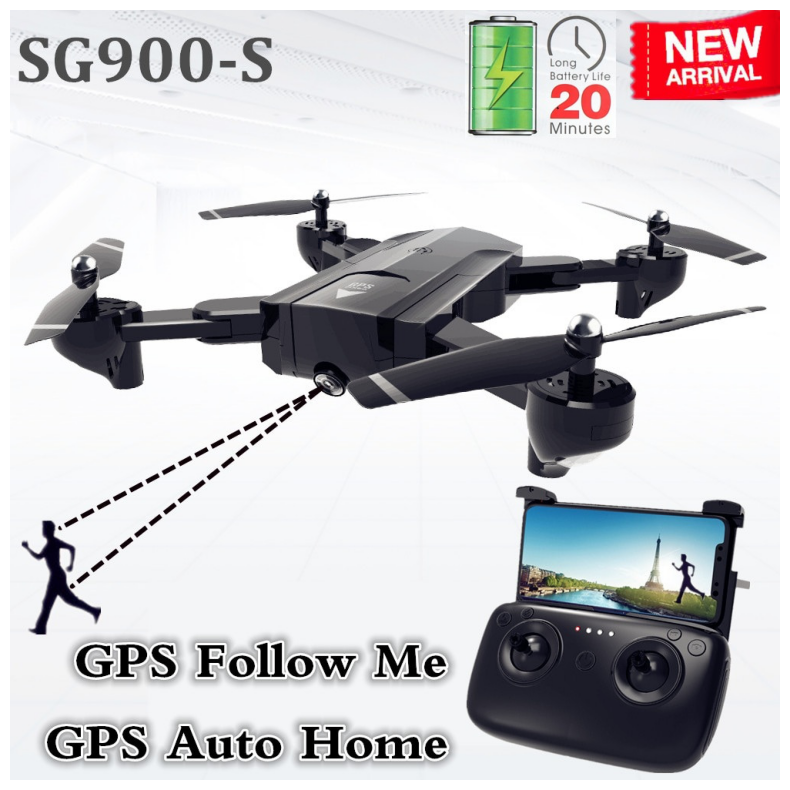

In [9]:

#@title Wybierz indeks przykładowego zdjęcia drona ze zbioru treningowego:

idx = 694 #@param {type:'slider', min:0, max:919}
names_mapping = dict(enumerate(drone_fnames))
img_path = os.path.join(train_drone_dir, names_mapping[idx])

img = image.load_img(img_path)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.grid(False)
plt.axis(False)

(-0.5, 1299.5, 952.5, -0.5)

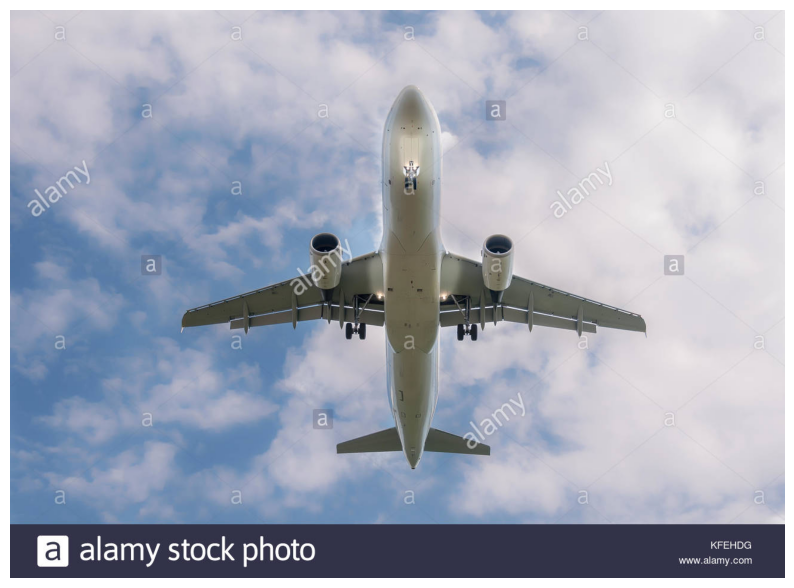

In [10]:

#@title Wybierz indeks przykładowego zdjęcia samolotu pasażerskiego ze zbioru treningowego:

idx = 699 #@param {type:'slider', min:0, max:919}
names_mapping = dict(enumerate(passenger_fnames))
img_path = os.path.join(train_passenger_dir, names_mapping[idx])

img = image.load_img(img_path)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.grid(False)
plt.axis(False)

## Augumentacja danych


In [11]:
train_datagen = ImageDataGenerator(
    rotation_range=40,     # zakres kąta o który losowo zostanie wykonany obrót obrazów
    rescale=1./255.,
    width_shift_range=0.2,  # pionowe przekształcenia obrazu
    height_shift_range=0.2, # poziome przekształcenia obrazu
    shear_range=0.2,        # zares losowego przycianania obrazu
    zoom_range=0.2,         # zakres losowego przybliżania obrazu
    horizontal_flip=True,   # losowe odbicie połowy obrazu w płaszczyźnie poziomej
    fill_mode='nearest'     # strategia wypełniania nowo utworzonych pikseli, któe mogą powstać w wyniku przekształceń
)

# przeskalowujemy wszystkie obrazy o współczynnik 1/255
valid_datagen = ImageDataGenerator(rescale=1./255.)

# flow_from_directory pozwala nam ladowoac dane prosto z naszego katalogu
# Bilblioteka keras wywnioskuje ze w tym katalogu sa foldery "drone" oraz "passenger" i uzna je za docelowe klasy
train_generator = train_datagen.flow_from_directory(directory=train_dir,
                                                   target_size=(150, 150),# zdiecia maja rozne rozmiary dlatego przedlozenie ich do sici musimy je wystandaryzowac
                                                   batch_size=32,
                                                   class_mode='binary')

valid_generator = valid_datagen.flow_from_directory(directory=valid_dir,
                                                   target_size=(150, 150),
                                                   batch_size=32,
                                                   class_mode='binary')

Found 1838 images belonging to 2 classes.
Found 524 images belonging to 2 classes.


# Budowa modelu

In [12]:
model = Sequential()
# Taka siec konwolucayjna sluzy do redukcji wymioarowosci i rozpoznawania przestrzennych cech z naszych zdiec
# Jesli w warstwie konwolucayjnej ( pozwala wykonac operacje splotu)
# rozmiar jadra czyli rozmiar filtru jest 3,3 to zabiera z kazdego wymiaru w input_shape po 2 jednostki
# I Output Shape jest 148 x 148
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(150, 150, 3)))
# Mxpooling czyli to okienko ktore nam lata po obrazie i wyciaga maxymalna wartosc piksela
# Maxpool dzieli przez 2 poniewaz mam tam okienko 2x2, wiec skaczemy sobie po obrazie co kazde okno
# # I Output Shape jest 74 x 74
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
# Przy kolejnej warstwie konwolucji "kernel_size=(3, 3)" zabiera znow po 2 jednostki z wymiarow
# # I Output Shape jest 72 x 72
model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
#  Kolejna warstwa Mxpooling dzieli przez 2 poniewaz mam tam okienko 2x2, wiec skaczemy sobie po obrazie co kazde okno
# # I Output Shape jest 36 x 36
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
# Przy kolejnej warstwie konwolucji "kernel_size=(3, 3)" zabiera znow po 2 jednostki z wymiarow
# # I Output Shape jest 34 x 34
model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
#  Kolejna warstwa Mxpooling dzieli przez 2 poniewaz mam tam okienko 2x2, wiec skaczemy sobie po obrazie co kazde okno
# # I Output Shape jest 17 x 17
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
# Przy kolejnej warstwie konwolucji "kernel_size=(3, 3)" zabiera znow po 2 jednostki z wymiarow
# # I Output Shape jest 15 x 15
model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
#  Kolejna warstwa Mxpooling dzieli przez 2 ale tu mamy liczbe nieparzysta wiec
#  Output Shape jest zaokraglany w dol 7 x 7
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
# Dzieki warstie Flatten wyplaszczamy sobie dane. Czyli wynik ktory zostal po warstwie MaxPool (None, 7, 7, 128)
# Zostaje wyplaszczony do rozmiaru (None, 6272)
model.add(layers.Flatten())
# Ters stosujemy warstwe gesto polaczona i ustawiamy 512 neuronow
model.add(layers.Dense(units=512, activation='relu'))
# Poniewaz jest to model binarny, to ustawiamy 1 i stosujemy funkcje sigmoid, bo chcemy miec zwrocone prawdopodobienstwo
model.add(layers.Dense(units=1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

In [13]:

model.compile(optimizer=optimizers.RMSprop(lr=1e-4),
             loss='binary_crossentropy',
             metrics=['accuracy'])

In [14]:
!rm -rf logs
!mkdir logs
# Tworzymy katalog z logami naszego trenowania
tensorboard = TensorBoard(log_dir='logs')

In [16]:

batch_size = 32
steps_per_epoch = train_size // batch_size
validation_steps = valid_size // batch_size

history = model.fit_generator(generator=train_generator,
                             steps_per_epoch=steps_per_epoch,
                             epochs=30,    # 100
                             validation_data=valid_generator,
                             validation_steps=validation_steps,
                             callbacks=[tensorboard])

<ipython-input-16-f5faffe4ff59>:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_generator,


Epoch 1/3
28/28 [==============================] - 27s 973ms/step - loss: 0.6952 - accuracy: 0.4855 - val_loss: 0.6917 - val_accuracy: 0.5859
Epoch 2/3
28/28 [==============================] - 31s 1s/step - loss: 0.6946 - accuracy: 0.4933 - val_loss: 0.6928 - val_accuracy: 0.5039
Epoch 3/3
28/28 [==============================] - 27s 950ms/step - loss: 0.6941 - accuracy: 0.5159 - val_loss: 0.6899 - val_accuracy: 0.5859


In [17]:
# %load_ext tensorboard

In [18]:
# !tensorboard dev upload --logdir logs

2023-07-06 21:36:38.012928: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

logs

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

To sign in with the TensorBoard uploader:

1. On your computer or phone, visit:

   https://www.google.com/device

2. Sign in with your Google account, then enter:

   PVV-JFY-MQH


Upload started and will continue reading any new data as it's added to the logdir.

To sto

In [21]:
def plot_hist(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  fig = go.Figure()
  fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['accuracy'], name='accuracy', mode='markers+lines'))
  fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['val_accuracy'], name='val_accuracy', mode='markers+lines'))
  fig.update_layout(width=1000, height=500, title='Accuracy vs. Val Accuracy', xaxis_title='Epoki', yaxis_title='Accuracy')
  fig.show()

  fig = go.Figure()
  fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['loss'], name='loss', mode='markers+lines'))
  fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['val_loss'], name='val_loss', mode='markers+lines'))
  fig.update_layout(width=1000, height=500, title='Loss vs. Val Loss', xaxis_title='Epoki', yaxis_title='Loss', yaxis_type='log')
  fig.show()

plot_hist(history)

# Transfer learning - model VGG16
Ta technika polega na tym, ze stosujemy gotowa architekture modelu oraz gotowe wagi, ktore zostaly przetrenowane na duzym zbiorze obrazow i o wielu roznych etykietach/klasach

In [ ]:
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
conv_base.summary()